In [42]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse import lil_matrix

Реализуем все алгоритмы из статьи [Dynamic trace estimation](https://arxiv.org/abs/2110.13752). Сначала все же начнем с вспомогательных функций

In [43]:
def RademacherVector(n: int):
    """
        Input:
            n: num of components
        Output:
            vec: random vector from Rademacher distribution
    """
    assert n > 0

    vec = np.random.binomial(1, 1/2, (n, 1))
    vec[vec == 0] = -1

    return vec

def RademacherMatrix(shape):
    """
        Input:
            shape: shape of the matrix
        Output:
            mat: random matrix from Rademacher distribution
    """
    mat = np.random.binomial(1, 1/2, shape)
    mat[mat == 0] = -1

    return mat

def Hutchinson(oracle, n: int, l: int):
    """
        Input:
            oracle: oracle for implicit matrix-vector multiplication with A
            n: size of the matrix A
            l: number of iteration to approximate the trace of the matrix A
        Output:
            approximation: approximation to the trace of A
    """

    assert l >= 0

    approximation = 0
    
    for iter in range(l):
        g = RademacherVector(n)
        approximation += g.T @ oracle(g)
    
    return approximation[0, 0] / l

def HutchinsonATA(oracle1, oracle2, n: int, l: int):
    """
        Input:
            oracle1: oracle for implicit matrix-vector multiplication with A
            oracle2: oracle for implicit matrix-vector multiplication with B
            n: size of the matrix A
            l: number of iteration to approximate the trace of the matrix A.T @ B
        Output:
            approximation: approximation to the trace of the matrix A.T @ B
    """

    assert l >= 0

    approximation = 0
    
    for iter in range(l // 2):
        g = RademacherVector(n)
        approximation += (oracle1(g)).T @ oracle2(g)
    
    return approximation[0, 0] / l

def SquaredFrobenius(oracle, n: int, l: int):
    """
        Input:
            oracle: oracle for implicit matrix-vector multiplication with A
            n: size of the matrix A
            l: number of iteration to approximate the frobenius norm of the matrix A
        Output:
            approximation: approximation to the frobenius norm of A
    """

    assert l >= 0

    approximation = 0
    
    for iter in range(l):
        g = oracle(RademacherVector(n))
        approximation += g.T @ g
    
    return approximation[0, 0] / l

def HutchinsonPlusPlus(oracle, n: int, l: int):
    """
        Input:
            oracle: oracle for implicit matrix-vector multiplication with A
            n: size of the matrix A
            l: number of iteration to approximate the trace of the matrix A
        Output:
            approximation: approximation to the trace of A
    """

    S = RademacherMatrix((n, l // 3))

    Q, _ = np.linalg.qr(oracle(S))

    return np.trace(Q.T @ oracle(Q)) + HutchinsonATA((lambda x: x - Q @ (Q.T @ x)), (lambda x: oracle(x - Q @ (Q.T @ x))), n, l - l // 3)

def HutchinsonPlusPlusWithQ(oracle, n: int, l: int):
    """
        Input:
            oracle: oracle for implicit matrix-vector multiplication with A
            n: size of the matrix A
            l: number of iteration to approximate the trace of the matrix A
        Output:
            approximation: approximation to the trace of A
            Q: matrix appended in the algorithm
    """
    
    S = RademacherMatrix((n, l // 3))

    Q, _ = np.linalg.qr(oracle(S))

    return np.trace(Q.T @ oracle(Q)) + HutchinsonATA((lambda x: x - Q @ (Q.T @ x)), (lambda x: oracle(x - Q @ (Q.T @ x))), n, l - l // 3), Q

Тут напишем для сравнения алгоритмы, не использующие информацию о близости соседних матриц.

In [44]:
def SimpleHutchinson(oracles, n: int, l: int):
    """
        Input:
            oracles: oracles for implicit matrix-vector multiplication with A1, ..., Am
            n: matrix size
            l: number of iteration to approximate the trace of the matrixes A1, ..., Am
        Output:
            approximation: list of approximations to the trace of A1, ..., Am
    """
    assert len(oracles) > 0

    approximation = []
    
    for i in range(len(oracles)):
        approximation.append(Hutchinson(oracles[i], n, l))
    
    return approximation

def SimpleHutchinsonPlusPlus(oracles, n: int, l: int):
    """
        Input:
            oracles: oracles for implicit matrix-vector multiplication with A1, ..., Am
            n: matrix size
            l: number of iteration to approximate the trace of the matrixes A1, ..., Am
        Output:
            approximation: list of approximations to the trace of A1, ..., Am
    """
    assert len(oracles) > 0

    approximation = []
    
    for i in range(len(oracles)):
        approximation.append(HutchinsonPlusPlus(oracles[i], n, l))
    
    return approximation

Напишем все возможные алгоритмы DeltaShift на основе обычного Хатчинсона.

In [45]:
def DeltaShift(oracles, n: int, l0: int, l: int, gamma: float):
    """
        Input:
            oracles: oracles for implicit matrix-vector multiplication with A1, ..., Am
            n: matrix size
            l0: number of iteration to approximate the trace of the matrix A1
            l: number of iteration to approximate the trace of the other matrixes
            gamma: damping factor
        Output:
            approximation: list of approximations to the trace of A1, ..., Am
    """
    assert len(oracles) > 0

    approximation = []
    approximation.append(Hutchinson(oracles[0], n, l0))
    
    for i in range(1, len(oracles)):
        approximation.append((1 - gamma) * approximation[i - 1]
                             +
                             Hutchinson((lambda x: oracles[i](x) - (1 - gamma) * oracles[i - 1](x)), n, l))
    
    return approximation

In [46]:
def ParameterFreeDeltaShift(oracles, n: int, l0: int, l: int):
    """
        Parameter free version of DeltaShift algorithm, gamma estimates inplace
        
        Input:
            oracles: oracles for implicit matrix-vector multiplication with A1, ..., Am
            n: matrix size
            l0: number of iteration to approximate the trace of the matrix A1
            l: number of iteration to approximate the trace of the other matrixes
        Output:
            approximation: list of approximations to the trace of A1, ..., Am
    """
    assert len(oracles) > 0

    approximation = [0]
    N = 0

    for _ in range(l0):
        g = RademacherVector(n)
        z = oracles[0](g)
        approximation[0] += (g.T @ z)[0, 0]
        N += (z.T @ z)[0, 0]

    approximation[0] /= l0
    N /= l0
    variance = 2 / l0 * N

    l //= 2
    
    for i in range(1, len(oracles)):
        z = []
        w = []
        g = []
        for j in range(l):
            cur = RademacherVector(n)
            z.append(oracles[i - 1](cur))
            w.append(oracles[i](cur))
            g.append(cur)

        N = 0
        M = 0
        C = 0
        for j in range(l):
            N += (z[j].T @ z[j])[0, 0] / l
            M += (w[j].T @ w[j])[0, 0] / l
            C += (w[j].T @ z[j])[0, 0] / l

        gamma = 1 - (2 * C) / (l * variance + 2 * N)

        t = (1 - gamma) * approximation[i - 1]
        for j in range(l):
            t += (g[j].T @ (w[j] - (1 - gamma) * z[j]))[0, 0] / l

        approximation.append(t)
        variance = (1 - gamma)**2 * variance + 2 / l * (M + (1 - gamma)**2 * N - 2 * (1 - gamma) * C)
    
    return approximation

In [47]:
def DeltaShiftRestart(oracles, n: int, l0: int, l: int, q: int):
    """
        DeltaShift algorithm, but restart every q iterations
        Input:
            oracles: oracles for implicit matrix-vector multiplication with A1, ..., Am
            n: matrix size
            l0: number of iteration to approximate the trace of the matrix A1
            l: number of iteration to approximate the trace of the other matrixes
            q: number of iterations to restart
        Output:
            approximation: list of approximations to the trace of A1, ..., Am
    """
    assert len(oracles) > 0

    approximation = []
    
    for i in range(len(oracles)):
        if i % q == 0:
            approximation.append(Hutchinson(oracles[i], n, l0))
        else:
            approximation.append(approximation[i - 1] +
                                 Hutchinson((lambda x: oracles[i](x) - oracles[i - 1](x)), n, l))
    
    return approximation

Теперь напишем все возможные алгоритмы DeltaShift++ на основе обычного Хатчинсона++.

In [48]:
def DeltaShiftPlusPlus(oracles, n: int, l0: int, l: int, gamma: float):
    """
        Use Hutch++ instead of simple Hutchinson
        Input:
            oracles: oracles for implicit matrix-vector multiplication with A1, ..., Am
            n: matrix size
            l0: number of iteration to approximate the trace of the matrix A1
            l: number of iteration to approximate the trace of the other matrixes
            gamma: damping factor
        Output:
            approximation: list of approximations to the trace of A1, ..., Am
    """
    assert len(oracles) > 0

    approximation = []
    approximation.append(HutchinsonPlusPlus(oracles[0], n, l0))
    
    for i in range(1, len(oracles)):
        approximation.append(gamma * HutchinsonPlusPlus(oracles[i], n, l // 2)
                             +
                             (1 - gamma) *
                             (approximation[i - 1] + HutchinsonPlusPlus((lambda x: oracles[i](x) - oracles[i - 1](x)), n, l // 2)))
    
    return approximation

In [49]:
def DeltaShiftPlusPlusRestart(oracles, n: int, l0: int, l: int, q: int):
    """
        DeltaShift++ algorithm, but restart every q iterations
        Input:
            oracles: oracles for implicit matrix-vector multiplication with A1, ..., Am
            n: matrix size
            l0: number of iteration to approximate the trace of the matrix A1
            l: number of iteration to approximate the trace of the other matrixes
            q: number of iterations to restart
        Output:
            approximation: list of approximations to the trace of A1, ..., Am
    """
    assert len(oracles) > 0

    approximation = []
    
    for i in range(len(oracles)):
        if i % q == 0:
            approximation.append(HutchinsonPlusPlus(oracles[i], n, l0))
        else:
            approximation.append(approximation[i - 1] + HutchinsonPlusPlus((lambda x: oracles[i](x) - oracles[i - 1](x)), n, l // 2))
    
    return approximation

In [50]:
def ParameterFreeDeltaShiftPlusPlus(oracles, n: int, l0: int, l: int):
    """
        Parameter free version of DeltaShift algorithm, gamma estimates inplace
        
        Input:
            oracles: oracles for implicit matrix-vector multiplication with A1, ..., Am
            n: matrix size
            l0: number of iteration to approximate the trace of the matrix A1
            l: number of iteration to approximate the trace of the other matrixes
        Output:
            approximation: list of approximations to the trace of A1, ..., Am
    """
    assert len(oracles) > 0

    approximation = []
    appr, Q = HutchinsonPlusPlusWithQ(oracles[0], n, l0)
    approximation.append(appr)

    variance = 2 / l0 * SquaredFrobenius((lambda x: oracles[0](x) - Q @ (Q.T @ oracles[0](x))), n, l0)

    
    for i in range(1, len(oracles)):
        appr1, Q1 = HutchinsonPlusPlusWithQ(oracles[i], n, l // 2)
        appr2, Q2 = HutchinsonPlusPlusWithQ((lambda x: oracles[i](x) - oracles[i - 1](x)), n, l // 2)
        K_A= SquaredFrobenius((lambda x: oracles[i](x) - Q1 @ (Q1.T @ oracles[i](x))), n, l // 2)
        K_delta = SquaredFrobenius((lambda x:
                                (oracles[i](x) - oracles[i - 1](x))
                                - Q2 @ (Q2.T @ (oracles[i](x) - oracles[i - 1](x)))
                                ), n, l // 2)

        gamma = (8 * K_delta + l // 2 * variance) / (8 * K_A + l // 2 * variance + 8 * K_delta)

        approximation.append(gamma * appr1
                             +
                             (1 - gamma) *
                             (approximation[i - 1] + appr2))
        variance = gamma**2 * 16 * K_A / l + (1  - gamma)**2 * (variance + 16 * K_delta / l)
    
    return approximation

Перейдем к тестированию алгоритмов. Возьмем граф города Иннополис и посмотрим как он менялся со временем.

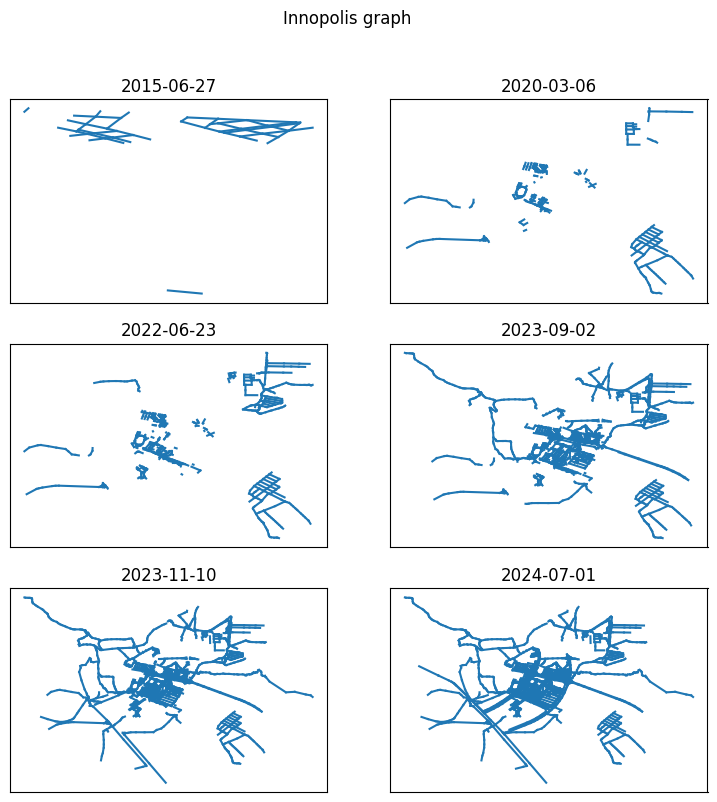

In [51]:
f = open('../data/innopolis.graph')

flag = False

fig, ax = plt.subplots(3, 2, figsize=(9, 9))
index_plot = 0

nodes = {}
data = []
nodes_num = {}
cnt = 0

adjency_matrix_innopolis = lil_matrix((3106, 3106))

adjency_array = []

fig.suptitle('Innopolis graph')

times = ['2015-06-10', '2015-06-16', '2015-06-17', '2015-06-27', '2015-08-13', '2016-11-30', '2017-03-05', '2017-04-02', '2017-08-04', '2017-08-21', '2019-05-07', '2019-07-06', '2019-07-24', '2019-09-16', '2019-10-03', '2019-10-23', '2020-03-06', '2020-04-18', '2020-08-27', '2020-11-09', '2021-01-19', '2021-02-01', '2021-03-25', '2021-07-07', '2021-07-09', '2021-10-01', '2021-12-18', '2021-12-20', '2022-05-12', '2022-06-23', '2022-09-17', '2022-12-19', '2023-01-20', '2023-03-13', '2023-03-14', '2023-04-04', '2023-07-05', '2023-07-09', '2023-08-25', '2023-08-30', '2023-08-31', '2023-09-01', '2023-09-02', '2023-09-03', '2023-09-06', '2023-09-07', '2023-09-09', '2023-09-10', '2023-09-13', '2023-09-24', '2023-09-26', '2023-10-22', '2023-10-23', '2023-11-01', '2023-11-02', '2023-11-10', '2023-12-03', '2024-02-17', '2024-02-27', '2024-03-18', '2024-04-22', '2024-06-18', '2024-07-01']
copy_times = times

for line in f.readlines():
    line = line[:-1]
    line = line.split()
    if 'Nodes' in line:
        continue
    if 'Edges' in line:
        flag = True
        continue
    if not(flag):
        nodes[line[0]] = (float(line[1]), float(line[2]))
    else:
        if not(nodes[line[2]] in nodes_num.keys()):
            nodes_num[nodes[line[2]]] = cnt
            cnt += 1
        if not(nodes[line[1]] in nodes_num.keys()):
            nodes_num[nodes[line[1]]] = cnt
            cnt += 1
        
        if len(times) > 3 and line[0] == times[3]:
            ax[index_plot // 2, index_plot % 2].plot(*data)
            ax[index_plot // 2, index_plot % 2].set_title(line[0])
            ax[index_plot // 2, index_plot % 2].get_xaxis().set_visible(False)
            ax[index_plot // 2, index_plot % 2].get_yaxis().set_visible(False)
            index_plot += 1
            if index_plot == 5:
                times = [0, 0, 0, times[len(times) - 1]]
            else:
                times = times[13:]

        adjency_matrix_innopolis[nodes_num[nodes[line[1]]], nodes_num[nodes[line[2]]]] = 1
        adjency_matrix_innopolis[nodes_num[nodes[line[2]]], nodes_num[nodes[line[1]]]] = 1

        data.append((nodes[line[1]][1], nodes[line[2]][1]))
        data.append((nodes[line[1]][0], nodes[line[2]][0]))
        data.append('C0')

        if len(copy_times) > 0 and line[0] == copy_times[0]:
            copy_times = copy_times[1:]
            adjency_array.append(adjency_matrix_innopolis.copy())


plt.show()

In [52]:
def CheckAlgorithms(oracles, n, correct_ans):
    """
        Generate graphic with relative error
        Input:
            oracles: list of oracle to compute matrix-vector multiplication
            n: matrix size
            correct_ans: list of the trace of the given matrixes
        Output:
            -
    """

    l0 = 100
    l = 50

    
    x = np.arange(len(oracles))
    correct_ans = np.array(correct_ans)

    simpl_hutchinson = np.array(SimpleHutchinson(oracles, n, l))
    plt.plot(x, abs(correct_ans - simpl_hutchinson) / max(correct_ans), label="Hutchinson")
    simpl_hutchinsonpp = np.array(SimpleHutchinsonPlusPlus(oracles, n, l))
    plt.plot(x,  abs(correct_ans - simpl_hutchinsonpp) / max(correct_ans), label="Hutchinson++")

    print("1")

    delta_shift = np.array(ParameterFreeDeltaShift(oracles, n, l0, l - 50 // 19))
    plt.plot(x, abs(correct_ans - delta_shift) / max(correct_ans), label="DeltaShift")
    delta_shift_r = np.array(DeltaShiftRestart(oracles, n, l0, l - 50 // 19, 20))
    plt.plot(x,  abs(correct_ans - delta_shift_r) / max(correct_ans), label="DeltaShift Restart")

    print("2")

    delta_shiftpp = np.array(ParameterFreeDeltaShiftPlusPlus(oracles, n, l0, l - 50 // 19))
    plt.plot(x, abs(correct_ans - delta_shiftpp) / max(correct_ans), label="DeltaShift++")
    delta_shiftpp_r = np.array(DeltaShiftPlusPlusRestart(oracles, n, l0, l - 50 // 19, 20))
    plt.plot(x,  abs(correct_ans - delta_shiftpp_r) / max(correct_ans), label="DeltaShift++ Restart")

    plt.legend()
    plt.xlabel("Time step(i)")
    plt.ylabel("$\\frac{|tr(A_i^3) - t_i|}{\max_i tr(A_i^3)}$")


    plt.show()

1
2


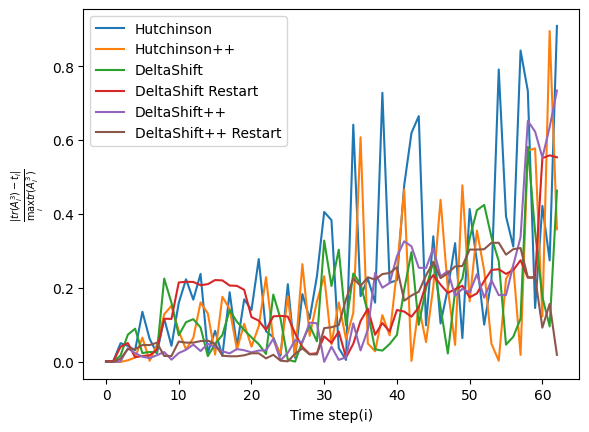

In [53]:
oracles = []
for i in range(len(adjency_array)):
    def a(i): 
        return (lambda x: adjency_array[i] @ (adjency_array[i] @ (adjency_array[i] @ x)))
    oracles.append(a(i))

correct_ans = []
for mat in adjency_array:
    correct_ans.append(np.trace(mat.toarray() @ mat @ mat))

CheckAlgorithms(oracles, adjency_array[0].shape[0], correct_ans)

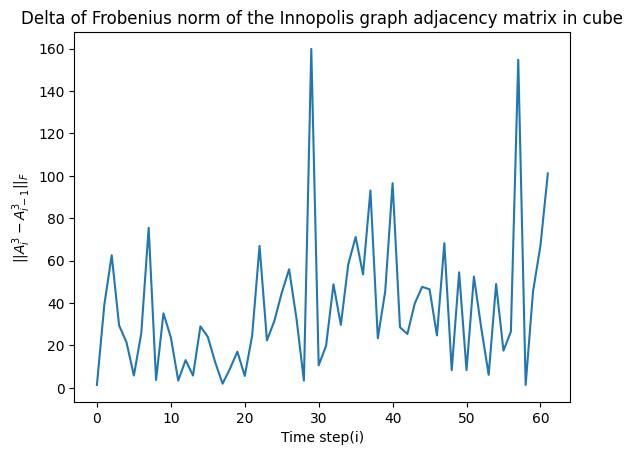

In [54]:
delta = []
for i in range(len(adjency_array) - 1):
    delta.append(np.linalg.norm(
        adjency_array[i].toarray() @ adjency_array[i] @ adjency_array[i]
        -
        adjency_array[i + 1].toarray() @ adjency_array[i + 1] @ adjency_array[i + 1]))

x = np.arange(len(oracles) - 1)
plt.plot(x, delta)

plt.title("Delta of Frobenius norm of the Innopolis graph adjacency matrix in cube")
plt.xlabel("Time step(i)")
plt.ylabel("$||A_i^3 - A_{i - 1}^3||_F$")


plt.show()